In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
df = pd.read_csv("/Users/AbidRehman/Abid/ucsd_courses/BENG285/Team_4_STAD/TCGA.STAD.mutations.txt", sep="\t")



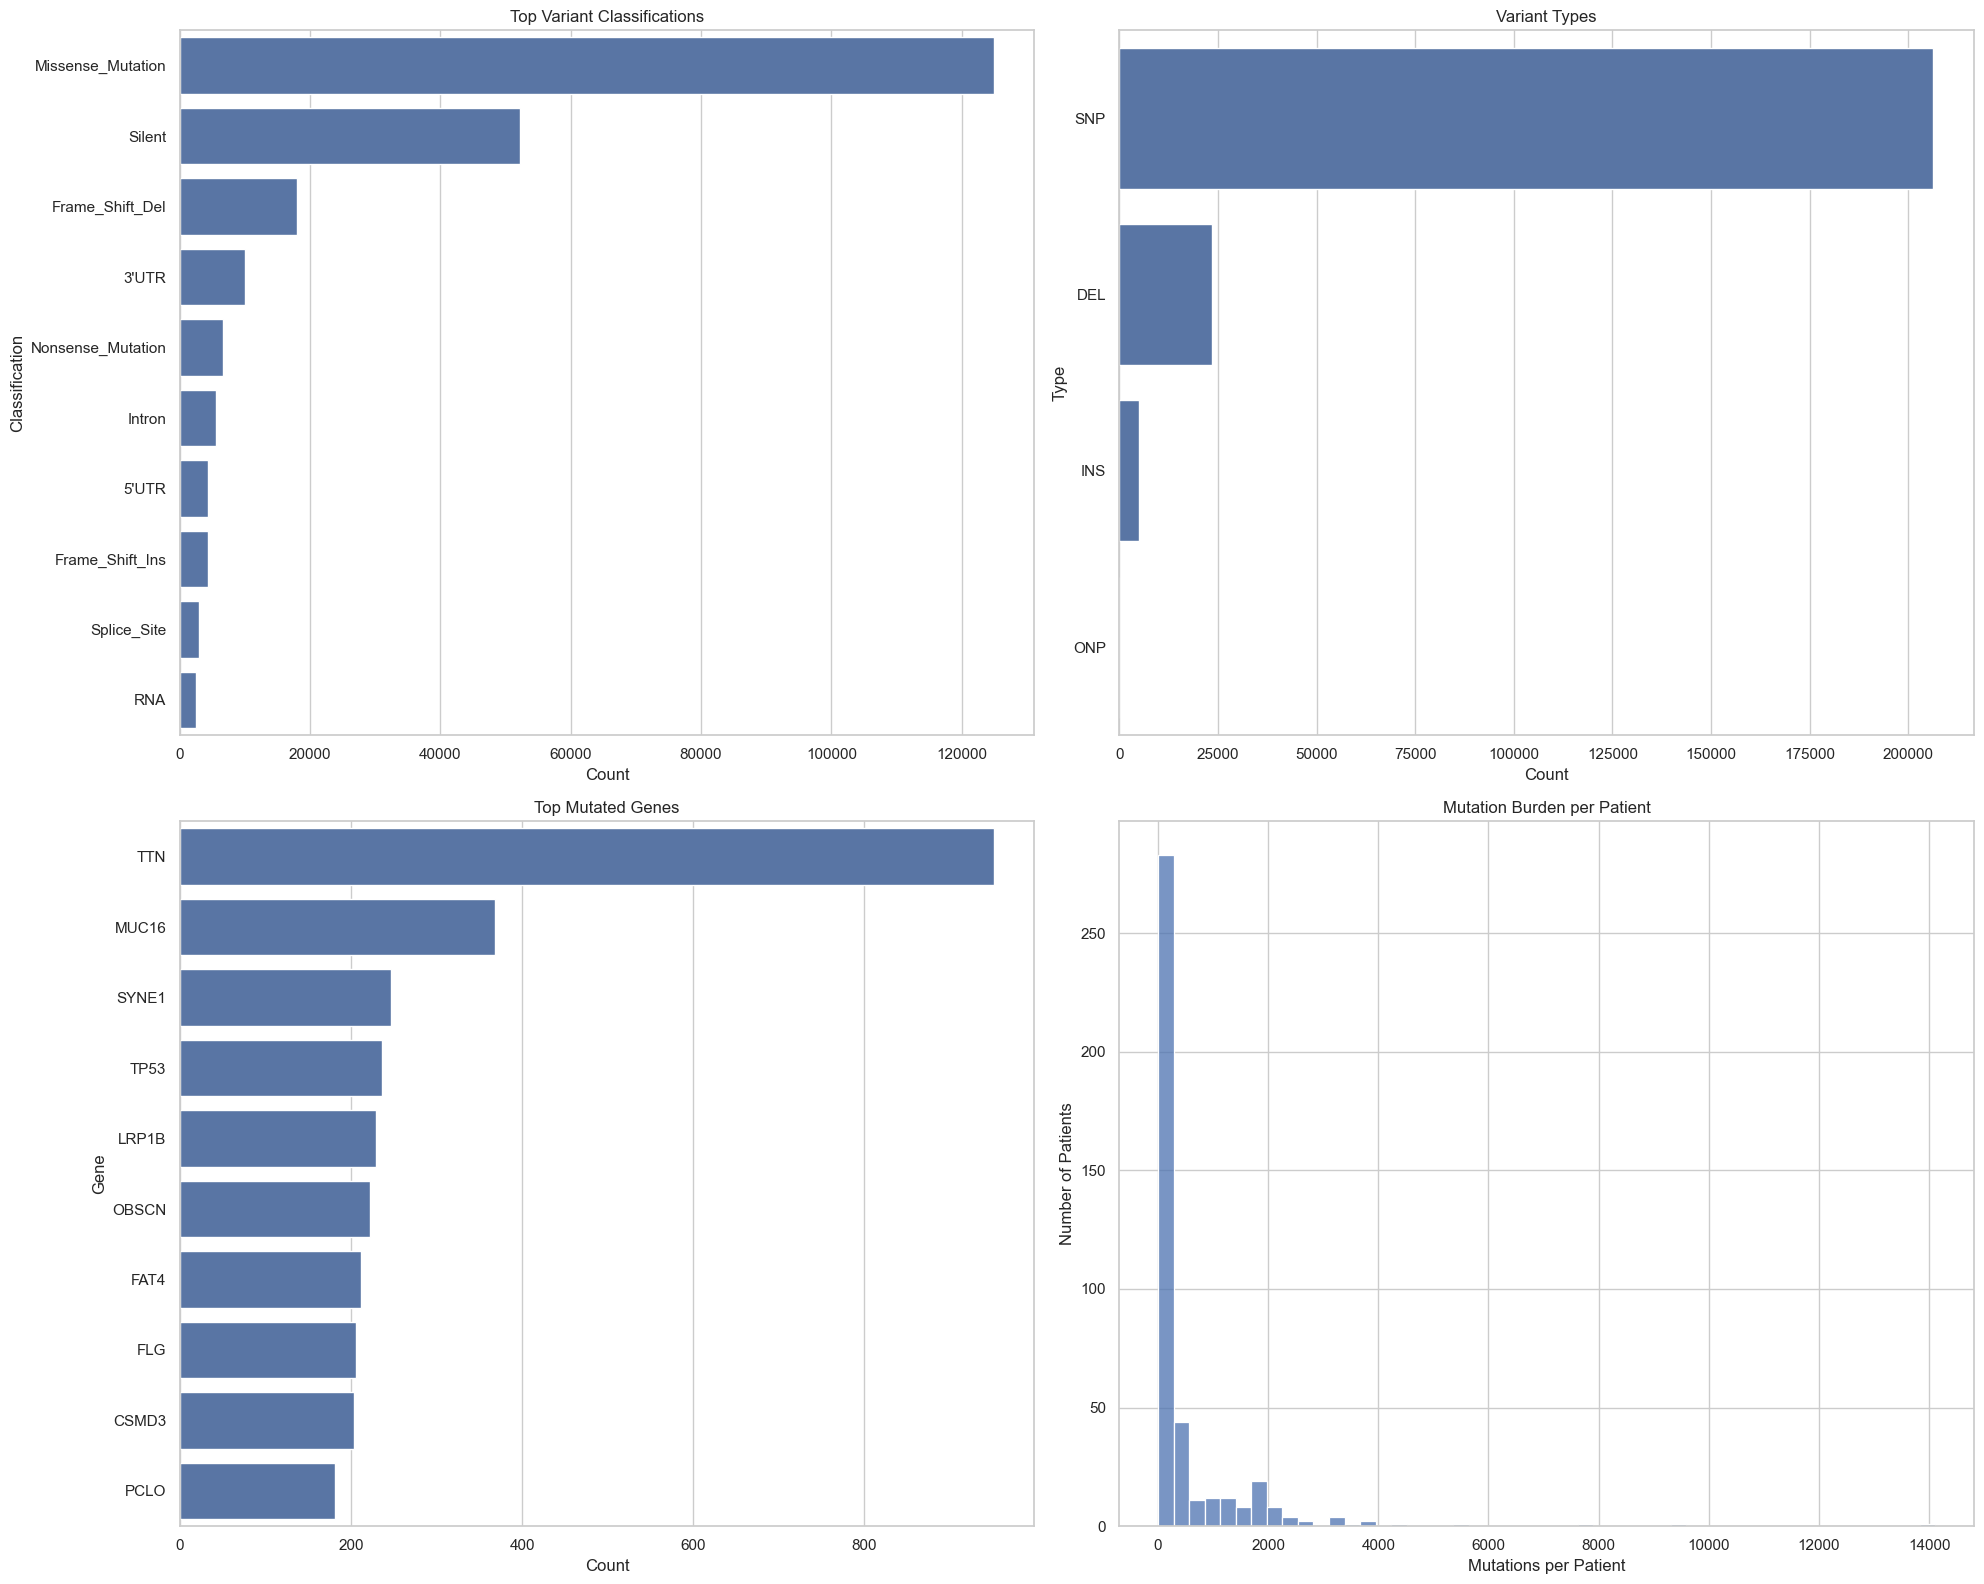

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Clean column names
df.columns = df.columns.str.strip()

# Set consistent style
sns.set(style="whitegrid")
plt.figure(figsize=(20, 16))

# 1. Variant Classification
plt.subplot(2, 2, 1)
vc_counts = df['Variant_Classification'].value_counts().head(10)
sns.barplot(x=vc_counts.values, y=vc_counts.index)
plt.title("Top Variant Classifications")
plt.xlabel("Count")
plt.ylabel("Classification")

# 2. Variant Type
plt.subplot(2, 2, 2)
vt_counts = df['Variant_Type'].value_counts()
sns.barplot(x=vt_counts.values, y=vt_counts.index)
plt.title("Variant Types")
plt.xlabel("Count")
plt.ylabel("Type")

# 3. Top Mutated Genes
plt.subplot(2, 2, 3)
gene_counts = df['Hugo_Symbol'].value_counts().head(10)
sns.barplot(x=gene_counts.values, y=gene_counts.index)
plt.title("Top Mutated Genes")
plt.xlabel("Count")
plt.ylabel("Gene")

# 4. Mutation Burden per Patient
plt.subplot(2, 2, 4)
patient_counts = df['patient_id'].value_counts()
sns.histplot(patient_counts, bins=50, kde=False)
plt.title("Mutation Burden per Patient")
plt.xlabel("Mutations per Patient")
plt.ylabel("Number of Patients")

plt.tight_layout()
plt.show()


In [3]:
#print(mutation_counts.columns.tolist())
# Count mutations per patient
mutation_counts = df['patient_id'].value_counts().sort_index()
#print(mutation_counts.columns.tolist())

mutation_counts

patient_id
TCGA-3M-AB46     233
TCGA-3M-AB47     148
TCGA-B7-5816    1713
TCGA-B7-5818     512
TCGA-B7-A5TI     830
                ... 
TCGA-VQ-AA6I     137
TCGA-VQ-AA6J     184
TCGA-VQ-AA6K      99
TCGA-ZA-A8F6      60
TCGA-ZQ-A9CR     148
Name: count, Length: 415, dtype: int64

Log10 split: 2.858
Exact split: 721 mutations


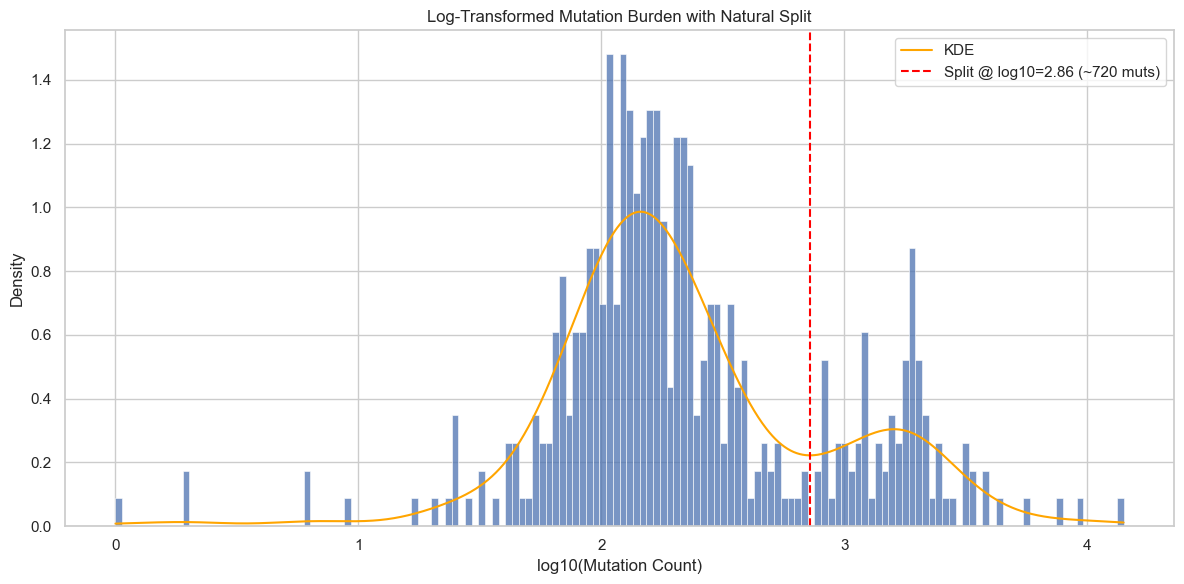

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

# Get mutation counts > 0
counts_array = mutation_counts[mutation_counts > 0].values.astype(float)
log_counts = np.log10(counts_array)

# KDE
kde = gaussian_kde(log_counts)
x_vals = np.linspace(log_counts.min(), log_counts.max(), 1000)
kde_vals = kde(x_vals)

# Restrict search to real bimodal region (log10 ≈ 1.5 to 3.5)
mask = (x_vals > 1.5) & (x_vals < 3.5)
x_zoom = x_vals[mask]
kde_zoom = kde_vals[mask]

# Find trough (local minimum)
troughs, _ = find_peaks(-kde_zoom)
if len(troughs) > 0:
    log_split = x_zoom[troughs[0]]
    exact_split = 10**log_split
    print(f"Log10 split: {log_split:.3f}")
    print(f"Exact split: {exact_split:.0f} mutations")
else:
    log_split = None
    print("No trough found.")

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(log_counts, bins=150, kde=False, stat="density")
plt.plot(x_vals, kde_vals, color='orange', label='KDE')

# Plot vertical line for the split
if log_split:
    plt.axvline(log_split, color='red', linestyle='--', label=f"Split @ log10={log_split:.2f} (~{int(exact_split)} muts)")

plt.xlabel("log10(Mutation Count)")
plt.ylabel("Density")
plt.title("Log-Transformed Mutation Burden with Natural Split")
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
# Get histogram bin edges from the KDE-aligned plot
hist_bins = np.histogram_bin_edges(log_counts, bins=50)

# Convert log bins to linear mutation counts
linear_bins = 10 ** hist_bins

# Find the largest bin edge that is still less than the exact split
bin_aligned_split = linear_bins[linear_bins < exact_split].max()

print(f"Adjusted split (previous bin edge): {bin_aligned_split:.0f} mutations")


Adjusted split (previous bin edge): 663 mutations


In [8]:
# Threshold based on natural split
threshold = 663  # or use int(exact_split) from your earlier KDE step

# Create mutation count dataframe
mutation_counts = df['patient_id'].value_counts().sort_index()
mutation_split_df = mutation_counts.to_frame(name="mutation_count")

# Assign groups
mutation_split_df["mutation_group"] = mutation_split_df["mutation_count"].apply(
    lambda x: "High" if x >= threshold else "Low"
)

# Split into patient ID lists
low_patients = mutation_split_df[mutation_split_df["mutation_group"] == "Low"].index.tolist()
high_patients = mutation_split_df[mutation_split_df["mutation_group"] == "High"].index.tolist()

# Filter original mutation rows
low_mut = df[df['patient_id'].isin(low_patients)]
high_mut = df[df['patient_id'].isin(high_patients)]

# Build mutation matrix
def build_mutation_matrix(df, context_col="CONTEXT", sample_col="patient_id"):
    mutation_matrix = (
        df.groupby([sample_col, context_col])
        .size()
        .unstack(fill_value=0)
        .sort_index()
    )
    return mutation_matrix

# Create the matrices
low_matrix = build_mutation_matrix(low_mut)
high_matrix = build_mutation_matrix(high_mut)


In [44]:
low_mut_filt = low_mut[low_mut.Variant_Type == "SNP"]
high_mut_filt = high_mut[high_mut.Variant_Type == "SNP"]
high_mut_filt["context_tri_ref"] = high_mut_filt["CONTEXT"].apply(lambda x: x[(len(x)-3)//2:(len(x)-3)//2+3])
low_mut_filt["context_tri_ref"] = low_mut_filt["CONTEXT"].apply(lambda x: x[(len(x)-3)//2:(len(x)-3)//2+3])

#low_mut_filt["context_tri_mut"] = low_mut_filt["context_tri_ref"]
low_mut_filt["context_tri_mut"] = low_mut_filt["context_tri_ref"].str[0] + low_mut_filt["Tumor_Seq_Allele2"].str[0] + low_mut_filt["context_tri_ref"].str[2]

low_mut_filt["context_full"] = low_mut_filt["context_tri_ref"] + ">" + low_mut_filt["context_tri_mut"]

low_mut_filt[["context_tri_ref", "context_tri_mut","Reference_Allele", "Tumor_Seq_Allele2", "context_full"]]
#low_mut_filt["Tumor_Seq_Allele2"] == low_mut_filt["CONTEXT"].str[3]
#low_mut_filt.columns
#sum(low_mut_filt.apply(lambda row: row["Reference_Allele"] == row["CONTEXT"][len(row["CONTEXT"]) // 2], axis=1))
#low_mut_filt[["CONTEXT", "context_tri"]]

/var/folders/rm/crp258qd4z98gqwbr_ny6xhr0000gn/T/ipykernel_97681/1203750235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_mut_filt["context_tri_ref"] = high_mut_filt["CONTEXT"].apply(lambda x: x[(len(x)-3)//2:(len(x)-3)//2+3])
/var/folders/rm/crp258qd4z98gqwbr_ny6xhr0000gn/T/ipykernel_97681/1203750235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_mut_filt["context_tri_ref"] = low_mut_filt["CONTEXT"].apply(lambda x: x[(len(x)-3)//2:(len(x)-3)//2+3])
/var/folders/rm/crp258qd4z98gqwbr_ny6x

,context_tri_ref,context_tri_mut,Reference_Allele,Tumor_Seq_Allele2,context_full
0,GGA,GCA,G,C,GGA>GCA
1,GTT,GGT,T,G,GTT>GGT
2,AGT,AAT,G,A,AGT>AAT
3,TGG,TAG,G,A,TGG>TAG
4,TGA,TAA,G,A,TGA>TAA
...,...,...,...,...,...
234935,TGC,TAC,G,A,TGC>TAC
234936,TGG,TTG,G,T,TGG>TTG
234937,TGC,TAC,G,A,TGC>TAC
234938,AAG,ACG,A,C,AAG>ACG


In [ ]:
# Align both series to same context index
all_contexts = sorted(set(low_matrix.columns).union(set(high_matrix.columns)))

low_sum = low_matrix.reindex(columns=all_contexts, fill_value=0).sum(axis=0)
high_sum = high_matrix.reindex(columns=all_contexts, fill_value=0).sum(axis=0)

# Normalize
low_norm = low_sum / low_sum.sum()
high_norm = high_sum / high_sum.sum()

# Plot
fig, ax = plt.subplots(figsize=(14, 5))
width = 0.4
x = np.arange(len(all_contexts))

ax.bar(x - width/2, low_norm.values, width=width, label='Low burden')
ax.bar(x + width/2, high_norm.values, width=width, label='High burden')

ax.set_xticks(x)
ax.set_xticklabels(all_contexts, rotation=90)
ax.set_ylabel("Proportion")
ax.set_title("Trinucleotide Mutation Context Spectrum")
ax.legend()
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [ ]:
from sklearn.decomposition import NMF

# Choose matrix: low or high
X = high_matrix.values  # or low_matrix.values
model = NMF(n_components=2, init='nndsvd', random_state=0, max_iter=1000)
W = model.fit_transform(X)  # patient × signature
H = model.components_       # signature × context

# Plot signatures
plt.figure(figsize=(12, 4))
for i, row in enumerate(H):
    plt.subplot(1, H.shape[0], i + 1)
    plt.bar(range(len(row)), row)
    plt.title(f'Signature {i+1}')
    plt.xticks(range(len(row)), high_matrix.columns, rotation=90)
    plt.tight_layout()


In [ ]:
print("W shape:", W.shape)  # rows: patients, columns: signatures
print("H shape:", H.shape)  # rows: signatures, columns: mutation contexts


/usr/local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1524: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1524: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1524: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/s

Best Parameters:
n_components                  8
init                     nndsvd
solver                       cd
max_iter                    500
reconstruction_err    34.688733
Name: 83, dtype: object


/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_99293/3917391618.py:77: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_99293/3917391618.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


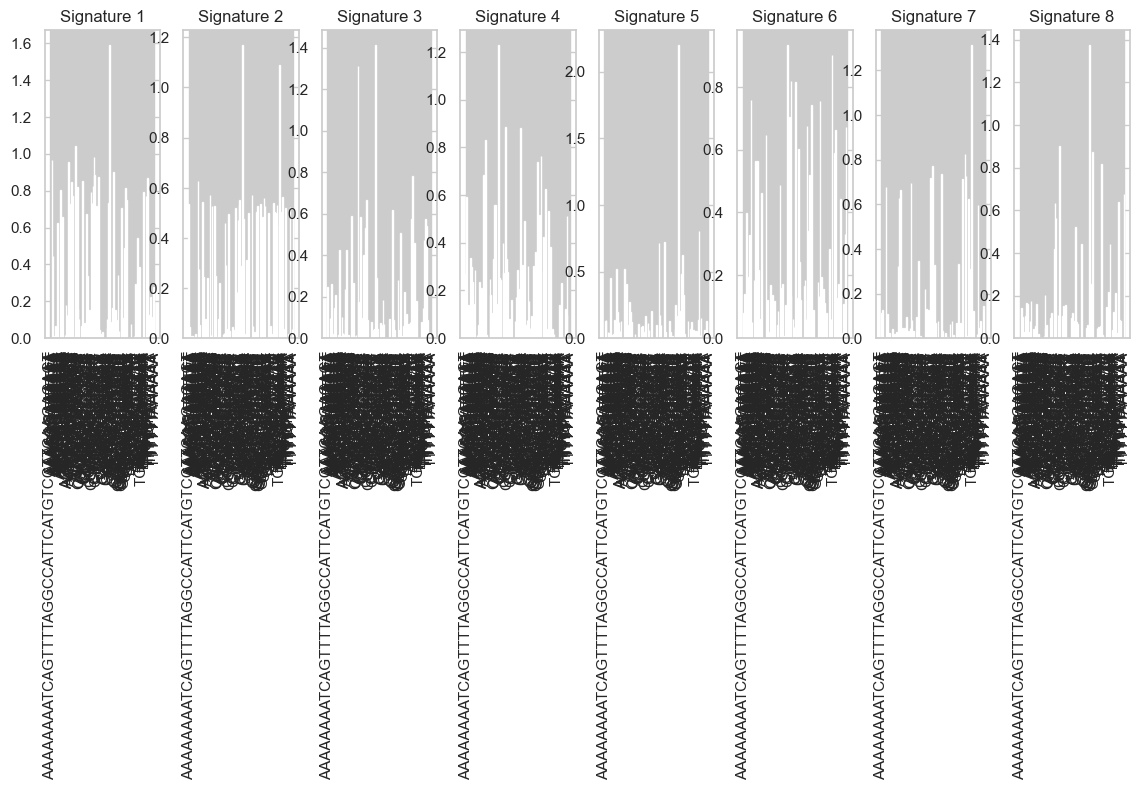

In [ ]:

#USE THIS NMF!!!!!!!!!
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools

# Step 1: Filter rare mutation contexts (keep all patients)
filtered_contexts = high_matrix.columns[high_matrix.sum() > 10]
X = high_matrix.loc[:, filtered_contexts].values

# Step 2: Define grid search
def grid_search_nmf(X, n_components_range, init_options, solver_options, iter_options):
    results = []
    for n_components, init, solver, max_iter in itertools.product(
        n_components_range, init_options, solver_options, iter_options
    ):
        try:
            model = NMF(
                n_components=n_components,
                init=init,
                solver=solver,
                max_iter=max_iter,
                random_state=0
            )
            model.fit(X)
            err = model.reconstruction_err_
            results.append({
                'n_components': n_components,
                'init': init,
                'solver': solver,
                'max_iter': max_iter,
                'reconstruction_err': err
            })
        except Exception as e:
            print(f"Skipped ({n_components}, {init}, {solver}, {max_iter}): {e}")
    return pd.DataFrame(results).sort_values('reconstruction_err')

# Step 3: Run grid search
param_grid = {
    'n_components_range': range(2, 9),  # Try 2–8 signatures
    'init_options': ['random', 'nndsvd'],
    'solver_options': ['mu', 'cd'],
    'iter_options': [200, 300, 500]
}

grid_results = grid_search_nmf(
    X,
    n_components_range=param_grid['n_components_range'],
    init_options=param_grid['init_options'],
    solver_options=param_grid['solver_options'],
    iter_options=param_grid['iter_options']
)

# Step 4: Select best configuration
best_params = grid_results.iloc[0]
print("Best Parameters:")
print(best_params)

# Step 5: Run NMF with best parameters
model = NMF(
    n_components=int(best_params['n_components']),
    init=best_params['init'],
    solver=best_params['solver'],
    max_iter=int(best_params['max_iter']),
    random_state=0
)
W = model.fit_transform(X)
H = model.components_

# Step 6: Plot signatures
plt.figure(figsize=(14, 4))
for i, row in enumerate(H):
    plt.subplot(1, H.shape[0], i + 1)
    plt.bar(range(len(row)), row)
    plt.title(f'Signature {i+1}')
    plt.xticks(range(len(row)), filtered_contexts, rotation=90)
    plt.tight_layout()
plt.show()


In [ ]:
print("W shape:", W.shape)  # rows: patients, columns: signatures
print("H shape:", H.shape)  # rows: signatures, columns: mutation contexts


W shape: (86, 8)
H shape: (8, 113)
